mBERT (Multilingual BERT) is a pre-trained transformer model developed by Google, designed to handle multiple languages using a single model. It is trained on Wikipedia text in 104 languages using a masked language modeling (MLM) objective.

In fake news detection project, mBERT is likely being used for:

Text Embeddings: Converting news text into meaningful vector representations.

Classification: Fine-tuning mBERT on a labeled dataset to classify news as real or fake.

Tokenizer: Using DistilBertTokenizerFast or BertTokenizer to preprocess text before feeding it into the model.

In [31]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import tensorflow as tf
from tensorflow import keras
from transformers import TrainingArguments

In [37]:
import pandas as pd

# Load dataset
dff = pd.read_csv("final_data.csv")

# Select first 5000 rows
first_5k = dff.iloc[:5000]

# Select last 15000 rows
last_15k = dff.iloc[5000:]

# Take 500 random rows from the first 5k
subset_1 = first_5k.sample(n=500, random_state=42)

# Take 1500 random rows from the last 15k
subset_2 = last_15k.sample(n=1500, random_state=42)

# Combine both subsets
df = pd.concat([subset_1, subset_2])

# Shuffle final dataset (optional)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Print dataset size
print(df.shape)  # Should be (2000, columns)


(2000, 2)


In [39]:
df.head(20)

,text,label
0,दुनिया में सबसे अधिक कर राष्ट्र थे।,1
1,"doral, fla./washington (reuters) - u.s. republ...",0
2,ஜோன் க்ளோப்பன்பர்க் ஒரு சமமான சமுதாயத்தை ஊக்கு...,0
3,SEATTLE (रायटर) - सिएटल की नगर परिषद ने सर्वसम...,0
4,जब अन्य लोगों के पैसे वेनेजुएला में एक एनजीओ क...,1
5,वाशिंगटन (रायटर) - राष्ट्रपति डोनाल्ड ट्रम्प क...,0
6,फॉक्स न्यूज ने राष्ट्रपति ओबामा को एक बार डोना...,1
7,सबसे खराब मंदी के दो साल बाद हम में से अधिकांश...,0
8,washington (reuters) - during a visit from sin...,0
9,మాజీ హౌస్ స్పీకర్ న్యూట్ జిన్రిచ్ ఆర్థిక వృద్ధ...,1


In [41]:
# Ensure correct column names
df = df.rename(columns={df.columns[0]: "text", df.columns[1]: "label"})

In [43]:
# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(df["text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42)


In [45]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

In [47]:
# Convert text column to string and handle missing values
df["text"] = df["text"].astype(str)  # Convert all values to string
df["label"] = df["label"].astype(int)  # Ensure labels are integers


In [49]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

In [51]:
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

In [53]:
import datasets
datasets.disable_progress_bars()

In [55]:
# Convert data to Hugging Face Dataset
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

In [57]:
print(train_dataset[0])  # Print first tokenized sample
print(val_dataset[0])

{'text': 'washington (reuters) - the story headlined “u.s. house tax panel chairman says flexible on mortgage deduction” published at 2050 gmt is withdrawn as u.s. house tax panel chairman kevin brady mistook the question which referred to property tax reductions in the republican tax reform plan announced earlier thursday.  there will be no replacement story.', 'label': 0, 'input_ids': [101, 10134, 30809, 11183, 113, 11639, 54092, 10107, 114, 118, 10105, 13617, 13578, 75066, 100, 189, 119, 187, 119, 13215, 25468, 36387, 27627, 22153, 81816, 10135, 12338, 93794, 10104, 54366, 100, 12304, 10160, 110044, 175, 18193, 10124, 84863, 10146, 189, 119, 187, 119, 13215, 25468, 36387, 27627, 11163, 15478, 67603, 12355, 12606, 86995, 10105, 20210, 10319, 19884, 10114, 18381, 25468, 51608, 10107, 10106, 10105, 108499, 10206, 25468, 34800, 13065, 13854, 18905, 23886, 10943, 24558, 119, 11155, 11337, 10347, 10192, 41636, 13617, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [59]:
model_path = "C:/models/bert-base-multilingual-cased"  # Adjust path as needed
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=len(set(df["label"])))
tokenizer = BertTokenizer.from_pretrained(model_path)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at C:/models/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
import transformers
print(transformers.__version__)  # Prints installed version


4.48.2


In [35]:
!pip install --upgrade transformers

In [39]:
!pip install --upgrade accelerate

In [63]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # ✅ Logs training loss every epoch
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)


In [65]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [67]:
# Train model
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.266462
2,No log,0.188540
3,0.235700,0.345475


TrainOutput(global_step=600, training_loss=0.22625314394632975, metrics={'train_runtime': 32770.1211, 'train_samples_per_second': 0.146, 'train_steps_per_second': 0.018, 'total_flos': 1262933065728000.0, 'train_loss': 0.22625314394632975, 'epoch': 3.0})

In [69]:
# Save model
model.save_pretrained("mbbert_fake_news")
tokenizer.save_pretrained("mbbert_fake_news")

('mbbert_fake_news\\tokenizer_config.json',
 'mbbert_fake_news\\special_tokens_map.json',
 'mbbert_fake_news\\vocab.txt',
 'mbbert_fake_news\\added_tokens.json')

In [71]:
print(trainer.state.log_history)

[{'eval_loss': 0.26646187901496887, 'eval_runtime': 369.1993, 'eval_samples_per_second': 1.083, 'eval_steps_per_second': 0.135, 'epoch': 1.0, 'step': 200}, {'eval_loss': 0.18854011595249176, 'eval_runtime': 567.7953, 'eval_samples_per_second': 0.704, 'eval_steps_per_second': 0.088, 'epoch': 2.0, 'step': 400}, {'loss': 0.2357, 'grad_norm': 0.16605998575687408, 'learning_rate': 8.333333333333334e-06, 'epoch': 2.5, 'step': 500}, {'eval_loss': 0.34547463059425354, 'eval_runtime': 356.5449, 'eval_samples_per_second': 1.122, 'eval_steps_per_second': 0.14, 'epoch': 3.0, 'step': 600}, {'train_runtime': 32770.1211, 'train_samples_per_second': 0.146, 'train_steps_per_second': 0.018, 'total_flos': 1262933065728000.0, 'train_loss': 0.22625314394632975, 'epoch': 3.0, 'step': 600}]


In [85]:
!pip install --upgrade datasets

In [87]:
import sys
!{sys.executable} -m pip show datasets

Name: datasets
Version: 3.2.0
Summary: HuggingFace community-driven open-source library of datasets
Home-page: https://github.com/huggingface/datasets
Author: HuggingFace Inc.
Author-email: thomas@huggingface.co
License: Apache 2.0
Location: C:\Users\vedas\anaconda3\Lib\site-packages
Requires: aiohttp, dill, filelock, fsspec, huggingface-hub, multiprocess, numpy, packaging, pandas, pyarrow, pyyaml, requests, tqdm, xxhash
Required-by: 


In [97]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)  # Convert logits to class predictions

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [99]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,  # ✅ Now using Scikit-Learn
)


In [101]:
eval_results = trainer.evaluate()
print(eval_results)  # ✅ Displays accuracy, precision, recall, and F1 score

{'eval_loss': 0.34547463059425354, 'eval_model_preparation_time': 0.0154, 'eval_accuracy': 0.8975, 'eval_precision': 0.8977054897631472, 'eval_recall': 0.8975, 'eval_f1': 0.8975521281338098, 'eval_runtime': 621.6676, 'eval_samples_per_second': 0.643, 'eval_steps_per_second': 0.08}


In [109]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)  # Convert logits to class predictions

    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}  # ✅ Returns only accuracy

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,  # ✅ Now calculates only accuracy
)


In [111]:
eval_results = trainer.evaluate()
print("Accuracy:", eval_results["eval_accuracy"])  # ✅ Prints only accuracy

Accuracy: 0.8975


In [119]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the fine-tuned model and tokenizer
model_path = "mbbert_fake_news"  # Path where you saved the model
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

# Set model to evaluation mode (no training)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [121]:
def predict_fake_news(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Convert logits to class (0 or 1)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()

    # Map prediction to label
    label_map = {0: "Real", 1: "Fake"}  # Adjust this if your labels are different
    return label_map[predicted_class]

In [123]:
news_text = "Breaking: Government launches new cybersecurity policy to combat online threats."
prediction = predict_fake_news(news_text)
print(f"Prediction: {prediction}")  # Output: "Real" or "Fake"

Prediction: Fake


In [127]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load fine-tuned model and tokenizer
model_path = "mbbert_fake_news"  # Make sure this path is correct
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

# Set model to evaluation mode (no training)
model.eval()

# Function to predict if news is real or fake
def predict_fake_news(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to class (0 or 1)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()

    # Map prediction to label
    label_map = {0: "Real", 1: "Fake"}  # Adjust based on your dataset labels
    return label_map[predicted_class]

# Ask for user input and predict
while True:
    news_text = input("Enter a news headline/article (or type 'exit' to quit): ")
    if news_text.lower() == 'exit':
        print("Exiting...")
        break
    prediction = predict_fake_news(news_text)
    print(f"Prediction: {prediction}")


Enter a news headline/article (or type 'exit' to quit):  	text 6	a texas republican congressman blamed female republicans for the gop s cruel health care bill, which would be more aptly named death care. rep. blake farenthold (r-tx) suggested that if they were men, he would challenge them to a gunfight.to make matters worse, he singled out the female republicans saying that it s absolutely repugnant that the gop-led senate hasn t had the ability to repeal the health care law even though they ve had seven years to come up with a viable alternative.farenthold called out the female senators from the northeast in reference to maine sen. susan collins, shelley moore capito of west virginia, and lisa murkowski of alaska (someone should point him to a map).on friday, during a radio interview on a corpus christi station last friday, farenthold said he finds it absolutely repugnant that the senate does not have the courage to do some of the things that every republican in the senate promised to

Prediction: Fake


Enter a news headline/article (or type 'exit' to quit):  90 percent of babies with down syndrome are aborted.


Prediction: Real


Enter a news headline/article (or type 'exit' to quit):  	text 14009	వాషింగ్టన్ (రాయిటర్స్) - యు.ఎస్.హౌస్ ఆఫ్ రిప్రజెంటేటివ్స్ స్పీకర్ పాల్ ర్యాన్ గురువారం మాట్లాడుతూ, రాబర్ట్ ముల్లెర్‌ను ప్రత్యేక న్యాయవాదిగా నియమించడం రష్యా మరియు 2016 యు.ఎస్.ఎన్నికలు.ర్యాన్ తన వీక్లీ వార్తా సమావేశంలో మాట్లాడుతూ గత రాత్రి డిప్యూటీ అటార్నీ జనరల్ రాడ్ రోసెన్‌స్టెయిన్ మరియు కాంగ్రెస్ నాయకులతో సమావేశంలో ఉందని, అయితే ఈ చర్చపై వ్యాఖ్యానించరని చెప్పారు.


Prediction: Real


Enter a news headline/article (or type 'exit' to quit):  	text 14010	ஒரு விருப்பம் எங்கே, ஒரு வழி இருக்கிறது, இந்த அற்புதமான மாணவர்களுக்கு நிச்சயமாக அவர்களின் விலைமதிப்பற்ற முதல் திருத்தத்தை சரியாகப் பாதுகாப்பதற்கான தேடலில் வெற்றிபெற விருப்பம் இல்லை!டிரம்ப் அத்தியாயத்திற்கான போர்ட்லேண்ட் ஸ்டேட் யுனிவர்சிட்டி மாணவர்கள் மீண்டும் வந்தனர், இந்த நேரத்தில் பில்ட் தி வால் என்ற நிகழ்வை நடத்தினர், அங்கு அவர்கள் உண்மையில் ஒரு பிரதி சுவரை வளாகத்திற்கு கொண்டு வந்தனர். முதல் வளாக காவல்துறையினர் அதை பல்கலைக்கழக சொத்தில் கொண்டு வர முடியாது என்று சொன்னார்கள்ஒரு கட்டமைப்பு மற்றும் அவர்களுக்கு அனுமதி இல்லை.இதைப் பற்றி மிகவும் சுவாரஸ்யமானது என்னவென்றால், வளாகத்தில் உள்ள வாக்ஜோப் எஸ்.ஜே.டபிள்யூ குழுக்கள் தங்கள் ஆர்ப்பாட்டங்கள் மற்றும் அணிவகுப்புகளின் போது கொள்கைக்குப் பிறகு கொள்கையை மீறுவதைத் தவிர்த்து வருகின்றன.அவர்கள் பெருக்கப்பட்ட சாதனங்களைப் பயன்படுத்துகிறார்கள், கட்டிடங்களின் அரங்குகள் வழியாக கத்துகிறார்கள், கத்துகிறார்கள், அவர்கள் உண்மையில் ஒரு பி.எஸ்.யூ அறங்காவலர் குழு கூட்டத்தை எடுத்துக் கொண்டனர்,

Prediction: Fake


Enter a news headline/article (or type 'exit' to quit):  	text 14013	வாஷிங்டன் (ராய்ட்டர்ஸ்) - யு.எஸ்.கியூபா ஜனாதிபதி ரவுல் காஸ்ட்ரோவின் “கொடுங்கோன்மை சர்வாதிகாரத்தை” இந்த பயணம் சட்டபூர்வமாக்குகிறது என்று ஜனாதிபதி பராக் ஒபாமாவின் கியூபாவுக்கு விஜயம் செய்ததாக பிரதிநிதிகள் சபாநாயகர் பால் ரியான் செவ்வாய்க்கிழமை கண்டித்தார்.ஒபாமா தனது வரலாற்று சிறப்புமிக்க ஹவானாவுக்குச் சென்றதால் ரியான் வாஷிங்டனில் செய்தியாளர்களிடம் தனது கருத்துக்களை தெரிவித்தார் - இது மனித உரிமை மீறல்கள் தொடர்பாக அமெரிக்க மற்றும் கியூபா தலைவர்களிடையே ஏற்பட்ட மோதல்களால் குறிக்கப்பட்ட பயணம்.


Prediction: Real


Enter a news headline/article (or type 'exit' to quit):  	text 14020	अधिक अमेरिकियों को निजी क्षेत्र में काम करने की तुलना में खाद्य सहायता प्राप्त होती है।


Prediction: Fake


Enter a news headline/article (or type 'exit' to quit):  	text 14035	TOKYO (रायटर) - जापान सटीक एयर -लॉन्च की गई मिसाइलों का अधिग्रहण करने की तैयारी कर रहा है, जो पहली बार उत्तर कोरियाई मिसाइल साइटों पर प्रहार करने की क्षमता देगी, इस मामले के प्रत्यक्ष ज्ञान के साथ दो स्रोतों ने कहा।जापान ने अप्रैल से शुरू होने वाले अपने अगले रक्षा बजट में पैसे डालने की योजना बनाई है कि क्या इसके एफ -15 फाइटर्स लॉकहीड मार्टिन कॉर्प एस एक्सटेंडेड-रेंज संयुक्त एयर-टू-सरफेस स्टैंडऑफ मिसाइल (JASSM-ER) सहित लंबी दूरी की मिसाइलों को लॉन्च कर सकते हैं, जो1,000 किमी (620 मील) दूर लक्ष्य को हिट कर सकते हैं, एक स्रोत ने कहा कि योजना के ज्ञान के साथ।लंबी दूरी की मिसाइलों का उपयोग करने के लिए एक वैश्विक प्रवृत्ति है और यह केवल स्वाभाविक है कि जापान उन पर विचार करना चाहेगा, उन्होंने कहा।सूत्रों ने गुमनाम रहने के लिए कहा क्योंकि वे मीडिया से बात करने के लिए अधिकृत नहीं थे।फूजी टेलीविजन ने पहले बताया कि जापान ने नॉर्वे के कोंग्सबर्ग डिफेंस एंड एयरोस्पेस द्वारा डिजाइन किए जाने वाले 500 किमी-रेंज संयुक्त स्ट्राइक मिसाइ

Prediction: Real


Enter a news headline/article (or type 'exit' to quit):  exit


Exiting...


In [129]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load fine-tuned model and tokenizer
model_path = "mbbert_fake_news"  # Make sure this path is correct
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

# Set model to evaluation mode (no training)
model.eval()

# Function to predict if news is real or fake
def predict_fake_news(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to class (0 or 1)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()

    # Map prediction to label
    label_map = {0: "Real", 1: "Fake"}  # Adjust based on your dataset labels
    return label_map[predicted_class]

# Ask for user input and predict
while True:
    news_text = input("Enter a news headline/article (or type 'exit' to quit): ")
    if news_text.lower() == 'exit':
        print("Exited")
        break
    prediction = predict_fake_news(news_text)
    print(f"Prediction: {prediction}")


Enter a news headline/article (or type 'exit' to quit):  ‘We didn’t give false hopes to the poor but brought real change’: PM Modi’s dig at Congress


Prediction: Fake


Enter a news headline/article (or type 'exit' to quit):  'Modi worships those ignored by everyone else': Prime Minister in Parliament


Prediction: Fake


Enter a news headline/article (or type 'exit' to quit):  	text 772	(reuters) - new abortion regulations took effect on tuesday in missouri that critics argue will make it more difficult for women to access the procedure. a judge on monday declined to block a requirement that physicians performing abortions inform their patients about abortion risks at least 72 hours before their procedure. previously, a different provider could give that mandated information. that means repeat doctor visits for women seeking abortions, some of whom must travel hundreds of miles to reach one of missouri’s three clinics, said bonyen lee-gilmore, a spokeswoman for planned parenthood great plains. there is also a shortage of abortion doctors, she said. the organization had sued to stop the new regulations because of the provider requirement. “this is about making it as difficult as possible to obtain an abortion,” lee-gilmore said in a phone interview on tuesday. “abortion access is chipped away one seemin

Prediction: Real


Enter a news headline/article (or type 'exit' to quit):  exit


Exited


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


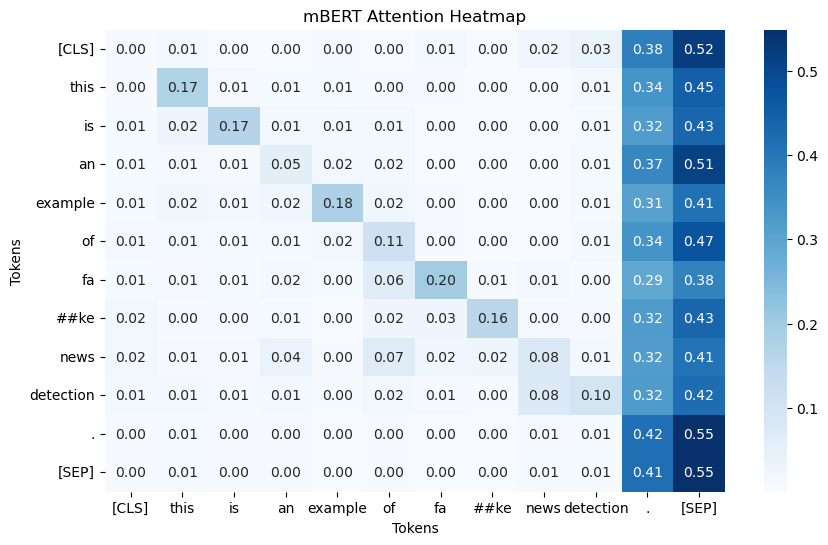

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification

# Load mBERT model & tokenizer
model_name = "mbbert_fake_news"  # Change if using a fine-tuned version
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, output_attentions=True)
model.eval()

# Input text
text = "This is an example of fake news detection."
tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
input_ids = tokens["input_ids"]

# Get model outputs (including attention scores)
with torch.no_grad():
    outputs = model(**tokens)

# Extract attention scores from the last layer
attention = outputs.attentions[-1]  # Shape: (batch_size, num_heads, seq_len, seq_len)
attention = attention.mean(dim=1).squeeze(0)  # Average over all heads

# Convert token IDs to words
tokens_list = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

# Plot Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(attention.numpy(), xticklabels=tokens_list, yticklabels=tokens_list, cmap="Blues", annot=True, fmt=".2f")
plt.title("mBERT Attention Heatmap")
plt.xlabel("Tokens")
plt.ylabel("Tokens")
plt.show()
